<center><span style="color:blue"><span style="font-size:30px">Credit Card Fraud Detection</span></span></center>

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise. 

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

In [1]:
#importing python packages 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve,average_precision_score,precision_recall_curve,classification_report,accuracy_score,precision_score,recall_score,f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV
from imblearn.over_sampling import SMOTE 
import keras
from keras.callbacks import Callback
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
#reading csv files
transactions = pd.read_csv('creditcard.csv',sep=',')

In [3]:
transactions.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
#test if there are some null values
transactions.isnull().values.any()

False

In [5]:
features=transactions.columns
features=features[:-1]#Class feature elimination

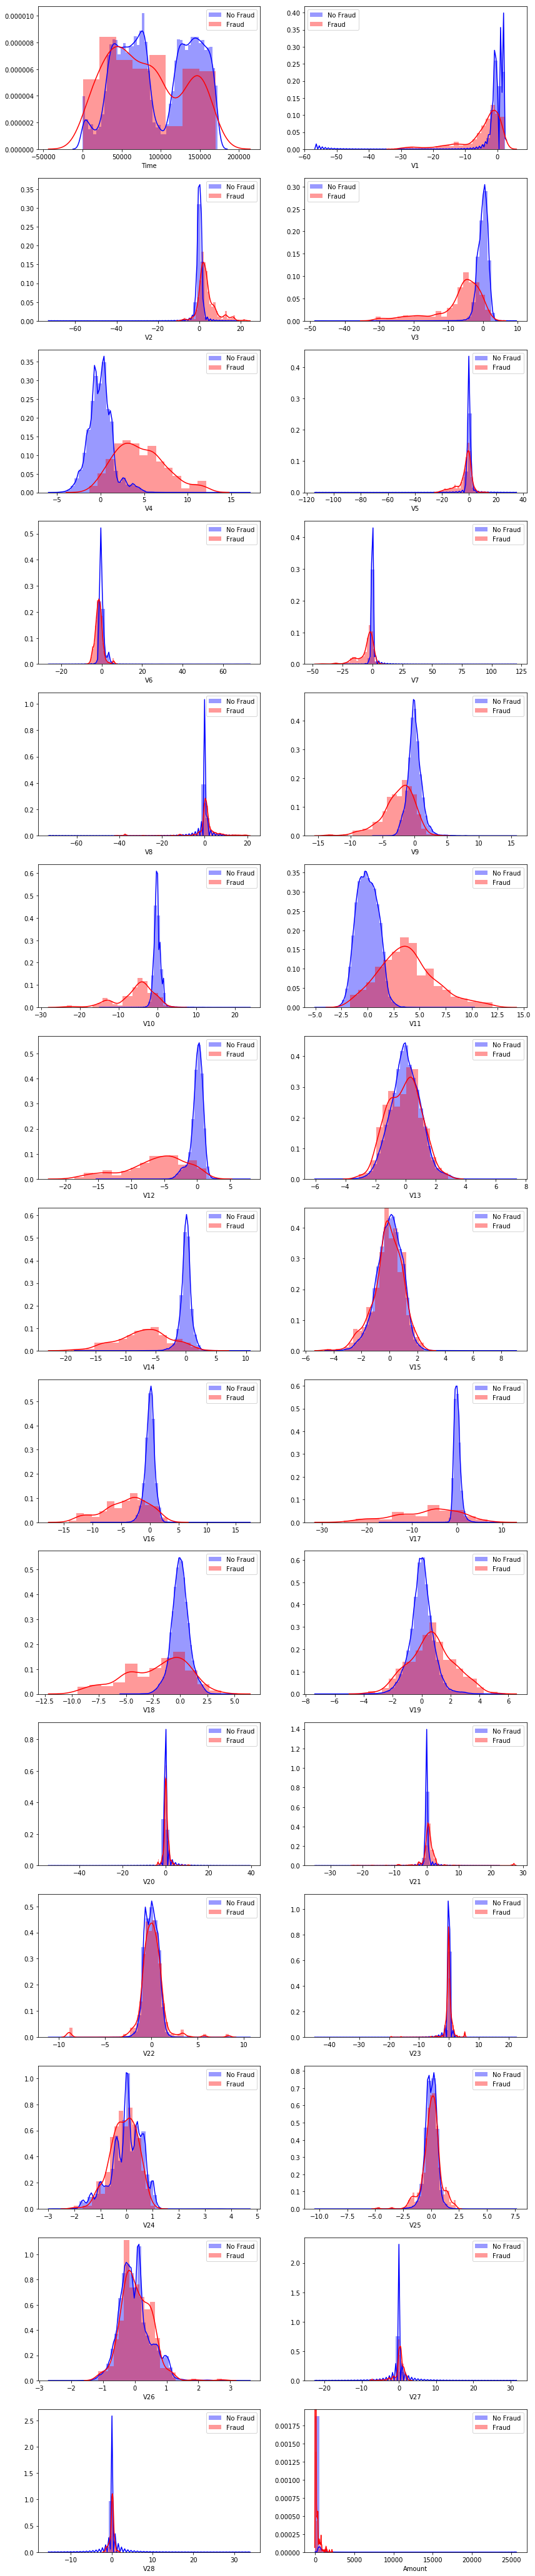

In [6]:
fig=plt.figure(figsize=(14,5*15))
gs = gridspec.GridSpec(15,2)
ax=[]
for i,v in enumerate(features):
    row = (i // 2)
    col = i % 2
    ax.append(fig.add_subplot(gs[row, col]))
    sns.distplot(transactions[v][transactions['Class']==0],color='b',label='No Fraud')
    sns.distplot(transactions[v][transactions['Class']==1],color='r',label='Fraud')
    ax[-1].legend()

We are going to suppress __Time__ feature because it is a sort of index that represents time elapsed from an initial transaction to present transaction and we cannot extract significant information from it.<br>
From several previous features histograms, we can notice that separation of fraudulent and non fraudulent transactions for those features will not be easy. But these features, except Time and Amount, have been obtained from PCA transformation, so we do not expect any improvement if we try to suppress one of these features.

In [7]:
transactions.drop(columns=['Time'],inplace=True)

In [8]:
transactions.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [9]:
transac_fraud=transactions[transactions['Class']==1]
transac_non_fraud=transactions[transactions['Class']==0]

In [10]:
transac_fraud['Amount'].describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [11]:
transac_non_fraud['Amount'].describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [12]:
transac_non_fraud.head(10)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


We are going to check if there is any strong relationship between features. We do expect very low correlations between features in the range (V1,..,V28) as they are obtained from a PCA. So the real checking will be the correlation of all those V1 till V28 features with __Amount__ feature.

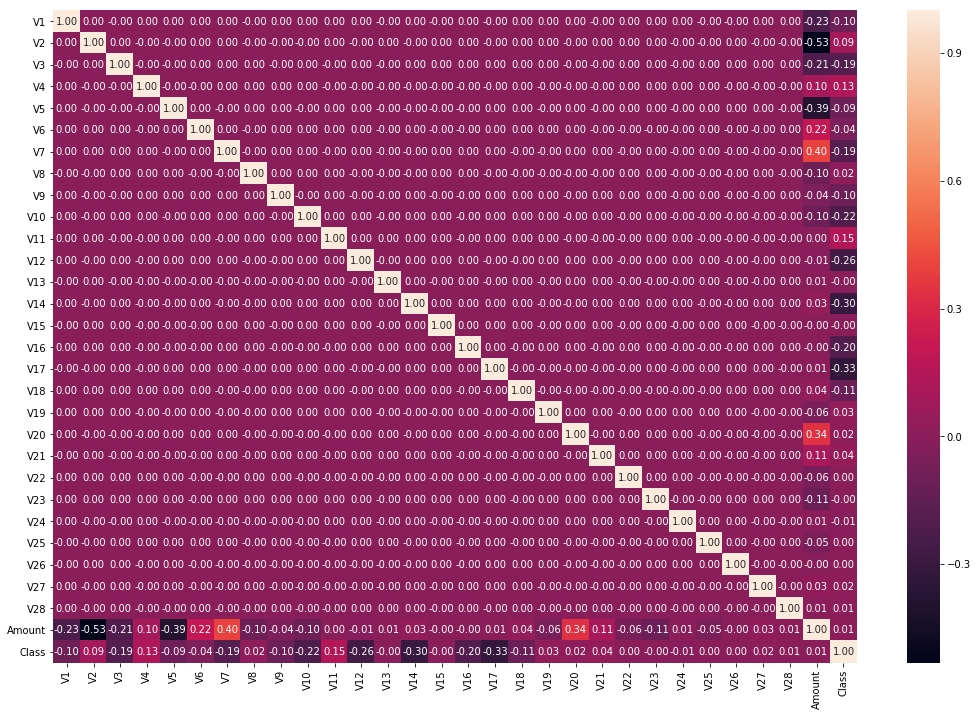

In [13]:
corr = transactions.corr()
plt.figure(figsize=(18,12)) 
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,annot=True, fmt='.2f')

We can check that there is no correlation between V1,...V28 features and there is no strong correlation of V1,..,V28 with __Amount__ feature. Correlation is not existing or it is weak for most of them and there is only a middle correlation of __Amount__ with __V2__ ,__V5__ and __V7__ features. However we will test furtherly if Amount feature suppression does not worsen results.

Before testing the models, we are going to split data into training and testing sets. We will also scale data which need normalisation. As V1,..,V28 are data obtaining from a PCA process they are already normalized. The only variables to scale are Time and Amount but as Time has been suppressed only Amount feature will be scaled.

In [14]:
X=transactions.copy()
X.drop(columns=['Class'],inplace=True)
y=transactions['Class'].values

In [15]:
X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y,test_size=0.3,random_state=15)

In [16]:
sc=StandardScaler()

In [17]:
X_train[['Amount']]=sc.fit_transform(X_train[['Amount']])
X_test[['Amount']]=sc.transform(X_test[['Amount']])

<span style="color:blue"><span style="font-size:25px">Models (train split)</span></span>

The metric for evaluating how good are our models will be, in this dataset, the area under the precision-recall curve. Precision-Recall is a useful measure of success of prediction when the classes are very imbalanced. The precision-recall curve shows the tradeoff between precision and recall for different thresholds. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).<br>
<br>There is a metric called average_precision which is precision averaged across all values of recall between 0 and 1. If we translate that definition to the precision-recall curve, the area under this curve can be approximated by this metric.
<br><br>Another known metric will added to give a more global idea of our results. This metric will be the area under the ROC curve. ROC curve is a performance measurement for classification problem at various thresholds settings. ROC is a probability curve and the area under the curve represents degree or measure of separability. It tells how much model is capable of distinguishing between classes. Higher the area under the curve, better the model is at predicting 0s as 0s and 1s as 1s.<br><br>
As most of the models give probabilities as predictions, in binary classifiers there is a default threshold which transform the probability in 0 or 1. This default theshold is 0.5. For this threshold we will add some more results as confusion matrix, precision and recall.

All the models that will be shown hereafter have been pretuned. A coarse tuning has been performed before, to reduce the number of values to be tested. So hereafter is a models fine tuning. 

<span style="color:red"><span style="font-size:18px">Logistic Regression</span></span>

Area under precision-recall curve (i.e. average_prediction_score) will be optimised and area under ROC curve,confusion matrix, recall and precision will be as well calculated. 

In [18]:
#tuning of C(inverse regularisation strength)
C=[0.01,0.05,0.1,0.5,1,10] 
opt_avg_prec=0
opt_C=C[0]
for i in C:
    lr_model=LogisticRegression(C=i,penalty='l2',random_state=0,n_jobs=-1)
    lr_model.fit(X_train,y_train)
    probs = lr_model.predict_proba(X_test)
    probs = probs[:, 1]
    if average_precision_score(y_test,probs)>opt_avg_prec:
        opt_avg_prec=average_precision_score(y_test,probs)
        opt_C=i

In [19]:
#predictions and calculation of confusion matrix
lr_model=LogisticRegression(penalty='l2',random_state=0,C=opt_C,n_jobs=-1)
lr_model.fit(X_train,y_train)
y_pred=lr_model.predict(X_test)
cm=confusion_matrix(y_test,y_pred)

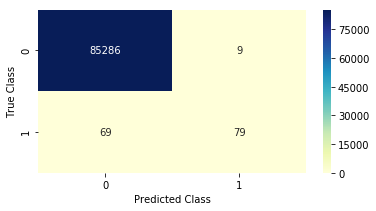

In [20]:
#confusion matrix plot
labels=[0,1]
plt.figure(figsize=(6,3))
sns.heatmap(cm,annot=True,cmap="YlGnBu",xticklabels=labels,yticklabels=labels,fmt='g')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

In [21]:
# main metrics report 
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.90      0.53      0.67       148

   micro avg       1.00      1.00      1.00     85443
   macro avg       0.95      0.77      0.83     85443
weighted avg       1.00      1.00      1.00     85443



In [22]:
#calculation of probabilities for ROC and Precision-Recall plotting
probs = lr_model.predict_proba(X_test)
probs = probs[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, probs)
fpr, tpr, thresholds = roc_curve(y_test, probs)

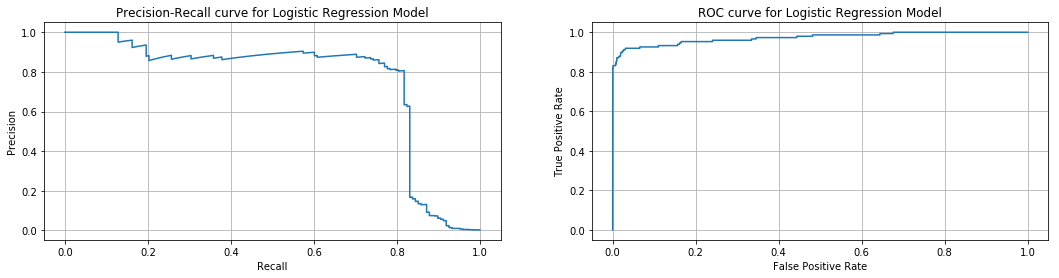

In [23]:
#precision-recall and ROC curves
fig=plt.figure(figsize=(18,4))
ax1 = fig.add_subplot(1,2,1)
plt.title("Precision-Recall curve for Logistic Regression Model")
ax1.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
ax2 = fig.add_subplot(1,2,2)
plt.title("ROC curve for Logistic Regression Model")
ax2.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid()
plt.show()

In [24]:
#calculation of areas under Precision-Recall curve and ROC curve
print("The area under the precision-recall curve is {:.3f}".format(average_precision_score(y_test,probs)))
print()
print("The area under the ROC curve is {:.3f}".format(roc_auc_score(y_test,probs)))

The area under the precision-recall curve is 0.754

The area under the ROC curve is 0.973


Recall and precision results are respectively 53% and 90% for fraudulent transactions. There are too many false negative predictions in the model. 

<span style="color:red"><span style="font-size:18px">Logistic Regression (balanced weights)</span></span>

Area under precision-recall curve (i.e. average_prediction_score) will be optimised and area under ROC curve,confusion matrix, recall and precision will be as well calculated. 

In [25]:
#tuning C(inverse regularisation strength)
C=[0.01,0.05,0.1,0.5,1,10] 
opt_avg_prec=0
opt_C=C[0]
for i in C:
    lr_model=LogisticRegression(C=i,penalty='l2',random_state=0,class_weight='balanced',n_jobs=-1)
    lr_model.fit(X_train,y_train)
    probs = lr_model.predict_proba(X_test)
    probs = probs[:, 1]
    if average_precision_score(y_test,probs)>opt_avg_prec:
        opt_avg_prec=average_precision_score(y_test,probs)
        opt_C=i

In [26]:
#predictions and calculation of confusion matrix
lr_model=LogisticRegression(penalty='l2',random_state=0,C=opt_C,class_weight='balanced',n_jobs=-1)
lr_model.fit(X_train,y_train)
y_pred=lr_model.predict(X_test)
cm=confusion_matrix(y_test,y_pred)

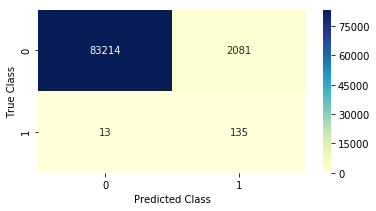

In [27]:
#confusion matrix plot
labels=[0,1]
plt.figure(figsize=(6,3))
sns.heatmap(cm,annot=True,cmap="YlGnBu",xticklabels=labels,yticklabels=labels,fmt='g')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

In [28]:
# main metrics report 
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85295
           1       0.06      0.91      0.11       148

   micro avg       0.98      0.98      0.98     85443
   macro avg       0.53      0.94      0.55     85443
weighted avg       1.00      0.98      0.99     85443



In [29]:
#calculation of probabilities for ROC and Precision-Recall plotting
probs = lr_model.predict_proba(X_test)
probs = probs[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, probs)
fpr, tpr, thresholds = roc_curve(y_test, probs)

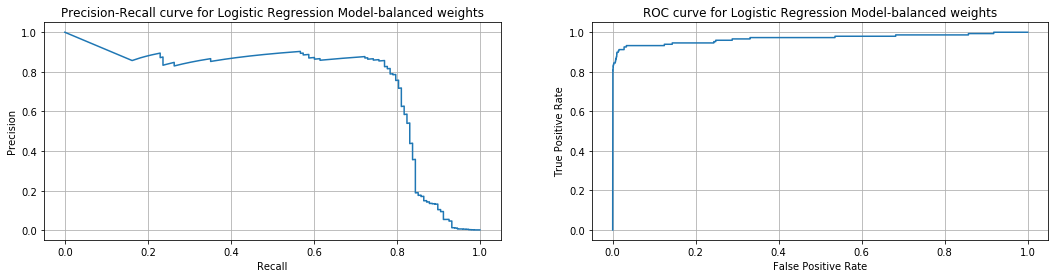

In [30]:
#precision-recall and ROC curves
fig=plt.figure(figsize=(18,4))
ax1 = fig.add_subplot(1,2,1)
plt.title("Precision-Recall curve for Logistic Regression Model-balanced weights")
ax1.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
ax2 = fig.add_subplot(1,2,2)
plt.title("ROC curve for Logistic Regression Model-balanced weights")
ax2.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid()
plt.show()

In [31]:
#calculation of areas under Precision-Recall curve and ROC curve
print("The area under the precision-recall curve is {:.3f}".format(average_precision_score(y_test,probs)))
print()
print("The area under the ROC curve is {:.3f}".format(roc_auc_score(y_test,probs)))

The area under the precision-recall curve is 0.729

The area under the ROC curve is 0.969


Recall and precision results are respectively 91% and 6% for fraudulent transactions. Balanced-weights parameter has improved significantly recall but has worsened completely precision result. There are too many false positive predictions in the model. 

<span style="color:red"><span style="font-size:18px">LinearSVC</span></span>

Concerning SVM, only the linear model will be considered. The non linear SVM models take a lot of execution time due to the fact that there are many features for a high number of rows.

Area under precision-recall curve (i.e. average_prediction_score) will be optimised and area under ROC curve,confusion matrix, recall and precision will be as well calculated.<br><br> As this model does not give probability predicitions, we will use CalibratedClassifier to obtain these probabilities and then calculate values for Precision-Recall and ROC curves. 

In [33]:
#tuning C (error term parameter)
C=[1.5,2,2.1]
opt_avg_prec=0
opt_C=C[0]
for i in C:
    lsvc_model=LinearSVC(C=i,random_state=0)
    lsvc_model.fit(X_train,y_train)
    sig_model = CalibratedClassifierCV(lsvc_model, method="sigmoid")
    sig_model.fit(X_train, y_train)
    probs = sig_model.predict_proba(X_test)
    probs = probs[:, 1]
    if average_precision_score(y_test,probs)>opt_avg_prec:
        opt__avg_prec=average_precision_score(y_test,probs)
        opt_C=i

In [34]:
#predictions and calculation of confusion matrix
lsvc_model=LinearSVC(C=opt_C,random_state=0)
lsvc_model.fit(X_train,y_train)
y_pred=lsvc_model.predict(X_test)
cm=confusion_matrix(y_test,y_pred)

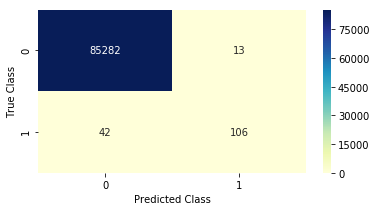

In [35]:
#confusion matrix plot
labels=[0,1]
plt.figure(figsize=(6,3))
sns.heatmap(cm,annot=True,cmap="YlGnBu",xticklabels=labels,yticklabels=labels,fmt='g')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

In [36]:
# main metrics report 
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.89      0.72      0.79       148

   micro avg       1.00      1.00      1.00     85443
   macro avg       0.95      0.86      0.90     85443
weighted avg       1.00      1.00      1.00     85443



In [37]:
#calculation of probabilities for ROC and Precision-Recall plotting
sig_model = CalibratedClassifierCV(lsvc_model, method="sigmoid")
sig_model.fit(X_train, y_train)
probs = sig_model.predict_proba(X_test)
probs = probs[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, probs)
fpr, tpr, thresholds = roc_curve(y_test, probs)

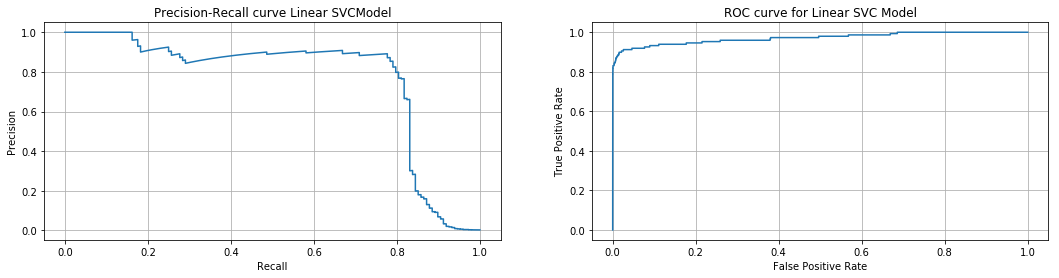

In [38]:
#precision-recall and ROC curves
fig=plt.figure(figsize=(18,4))
ax1 = fig.add_subplot(1,2,1)
plt.title("Precision-Recall curve Linear SVCModel")
ax1.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
ax2 = fig.add_subplot(1,2,2)
plt.title("ROC curve for Linear SVC Model")
ax2.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid()
plt.show()

In [39]:
#calculation of areas under Precision-Recall curve and ROC curve
print("The area under the precision-recall curve is {:.3f}".format(average_precision_score(y_test,probs)))
print()
print("The area under the ROC curve is {:.3f}".format(roc_auc_score(y_test,probs)))

The area under the precision-recall curve is 0.767

The area under the ROC curve is 0.971


Recall and precision results are respectively 72% and 89% for fraudulent transactions. 

<span style="color:red"><span style="font-size:18px">RandomForest</span></span>

Area under precision-recall curve (i.e. average_prediction_score) will be optimised and area under ROC curve,confusion matrix, recall and precision will be as well calculated.

In [40]:
#tuning the number of trees and minimum number of samples required to be at a leaf node
n_estimators=[140,150,160]
min_samples_leaf=[2,3,4]
opt_avg_prec=0
opt_est=n_estimators[0]
opt_leaf=min_samples_leaf[0]
for i in n_estimators:
    for j in min_samples_leaf:
        rf_model=RandomForestClassifier(n_estimators=i,min_samples_leaf=j,random_state=14,n_jobs=-1)
        rf_model.fit(X_train,y_train)
        probs = rf_model.predict_proba(X_test)
        probs = probs[:, 1]
        if average_precision_score(y_test,probs)>opt_avg_prec:
            opt_avg_prec=average_precision_score(y_test,probs)
            opt_est=i
            opt_leaf=j

In [41]:
#predictions and calculation of confusion matrix
rf_model=RandomForestClassifier(n_estimators=opt_est,min_samples_leaf=opt_leaf,random_state=14,n_jobs=-1)
rf_model.fit(X_train,y_train)
y_pred=rf_model.predict(X_test)
cm=confusion_matrix(y_test,y_pred)

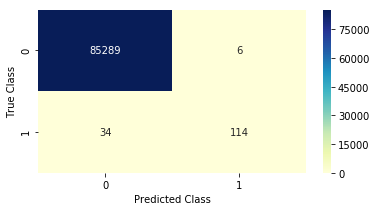

In [42]:
#confusion matrix plot
labels=[0,1]
plt.figure(figsize=(6,3))
sns.heatmap(cm,annot=True,cmap="YlGnBu",xticklabels=labels,yticklabels=labels,fmt='g')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

In [43]:
#metrics report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.95      0.77      0.85       148

   micro avg       1.00      1.00      1.00     85443
   macro avg       0.97      0.89      0.93     85443
weighted avg       1.00      1.00      1.00     85443



In [44]:
#calculation of probabilities for ROC and Precision-Recall plotting
probs = rf_model.predict_proba(X_test)
probs = probs[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, probs)
fpr, tpr, thresholds = roc_curve(y_test, probs)

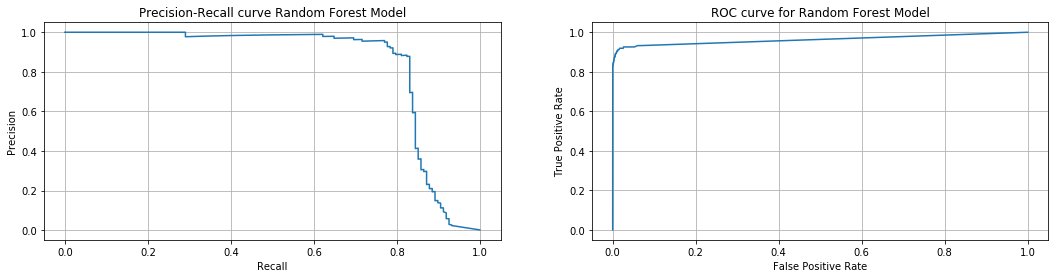

In [45]:
#precision-recall and ROC curves
fig=plt.figure(figsize=(18,4))
ax1 = fig.add_subplot(1,2,1)
plt.title("Precision-Recall curve Random Forest Model")
ax1.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
ax2 = fig.add_subplot(1,2,2)
plt.title("ROC curve for Random Forest Model")
ax2.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid()
plt.show()

In [46]:
#calculation of areas under Precision-Recall curve and ROC curve
print("The area under the precision-recall curve is {:.3f}".format(average_precision_score(y_test,probs)))
print()
print("The area under the ROC curve is {:.3f}".format(roc_auc_score(y_test,probs)))

The area under the precision-recall curve is 0.841

The area under the ROC curve is 0.963


Recall and precision results are respectively 77% and 95% for fraudulent transactions. 

<span style="color:red"><span style="font-size:18px">KNN</span></span>

Area under precision-recall curve (i.e. average_prediction_score) will be optimised and area under ROC curve,confusion matrix, recall and precision will be as well calculated.

In [47]:
#Tuning number of neigbours 
neighbours=[7,8,9,10]
opt_avg_prec=0
opt_neighbour=neighbours[0]
for i in neighbours:
    knn_model=KNeighborsClassifier(n_neighbors=i,n_jobs=-1)
    knn_model.fit(X_train,y_train)
    probs = knn_model.predict_proba(X_test)
    probs = probs[:, 1]
    if average_precision_score(y_test,probs)>opt_avg_prec:
        opt_avg_prec=average_precision_score(y_test,probs)
        opt_neighbour=i

In [48]:
#predictions and calculation of confusion matrix
knn_model=KNeighborsClassifier(n_neighbors=opt_neighbour,n_jobs=-1)
knn_model.fit(X_train,y_train)
y_pred=knn_model.predict(X_test)
cm=confusion_matrix(y_test,y_pred)

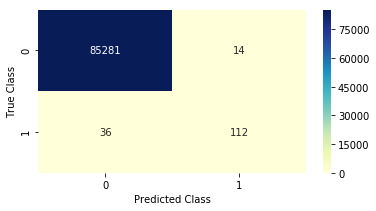

In [49]:
#confusion matrix plot
labels=[0,1]
plt.figure(figsize=(6,3))
sns.heatmap(cm,annot=True,cmap="YlGnBu",xticklabels=labels,yticklabels=labels,fmt='g')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

In [50]:
#metrics report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.89      0.76      0.82       148

   micro avg       1.00      1.00      1.00     85443
   macro avg       0.94      0.88      0.91     85443
weighted avg       1.00      1.00      1.00     85443



In [51]:
#calculation of probabilities for ROC and Precision-Recall plotting
probs = knn_model.predict_proba(X_test)
probs = probs[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, probs)
fpr, tpr, thresholds = roc_curve(y_test, probs)

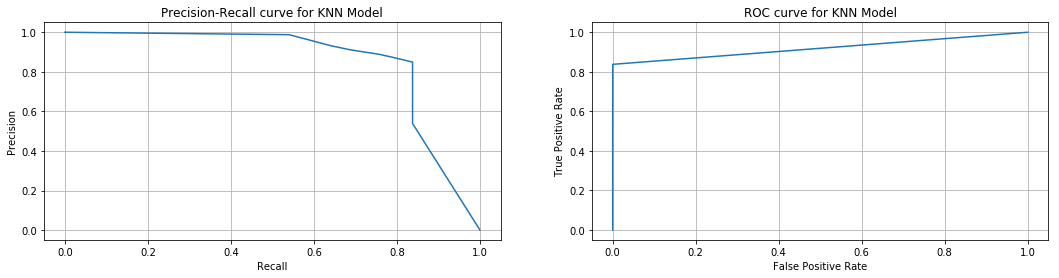

In [52]:
#precision-recall and ROC curves
fig=plt.figure(figsize=(18,4))
ax1 = fig.add_subplot(1,2,1)
plt.title("Precision-Recall curve for KNN Model")
ax1.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
ax2 = fig.add_subplot(1,2,2)
plt.title("ROC curve for KNN Model")
ax2.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid()
plt.show()

In [53]:
#calculation of areas under Precision-Recall curve and ROC curve
print("The area under the precision-recall curve is {:.3f}".format(average_precision_score(y_test,probs)))
print()
print("The area under the ROC curve is {:.3f}".format(roc_auc_score(y_test,probs)))

The area under the precision-recall curve is 0.801

The area under the ROC curve is 0.919


Recall and precision results are respectively 76% and 89% for fraudulent transactions. 

<span style="color:red"><span style="font-size:18px">XGBoost</span></span>

Area under precision-recall curve (i.e. average_prediction_score) will be optimised and area under ROC curve,confusion matrix, recall and precision will be as well calculated.

In [54]:
#tuning number of trees and learning rate
#parameter scale_pos_weight is modified to take into account imbalance data
learning=[0.1,0.15,0.2]
estimators=[100,200,300]
opt_avg_prec=0
opt_learning=learning[0]
opt_est=estimators[0]
for i in learning:
    for j in estimators:
        xgb_model=XGBClassifier(learning_rate =i,n_estimators=j,
        max_depth=6,min_child_weight=1,gamma=0,subsample=0.8,colsample_bytree=0.8,
        objective= 'binary:logistic',nthread=4,scale_pos_weight=20,seed=20,n_jobs=-1)
        xgb_model.fit(X_train,y_train)
        probs = xgb_model.predict_proba(X_test)
        probs = probs[:, 1]
        if average_precision_score(y_test,probs)>opt_avg_prec:
            opt_avg_prec=average_precision_score(y_test,probs)
            opt_learning=i
            opt_est=j    

In [55]:
#predictions and calculation of confusion matrix
xgb_model=XGBClassifier(learning_rate =opt_learning,n_estimators=opt_est,
        max_depth=6,min_child_weight=1,gamma=0,subsample=0.8,colsample_bytree=0.8,
        objective= 'binary:logistic',nthread=4,scale_pos_weight=20,seed=20,n_jobs=-1)
xgb_model.fit(X_train,y_train)
y_pred=xgb_model.predict(X_test)
cm=confusion_matrix(y_test,y_pred)

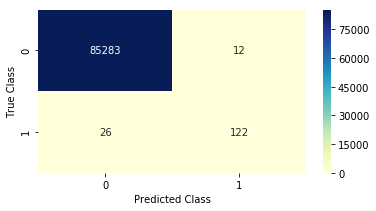

In [56]:
#confusion matrix plot
labels=[0,1]
plt.figure(figsize=(6,3))
sns.heatmap(cm,annot=True,cmap="YlGnBu",xticklabels=labels,yticklabels=labels,fmt='g')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

In [57]:
#metrics report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.91      0.82      0.87       148

   micro avg       1.00      1.00      1.00     85443
   macro avg       0.96      0.91      0.93     85443
weighted avg       1.00      1.00      1.00     85443



In [58]:
#calculation of probabilities for ROC and Precision-Recall plotting
probs = xgb_model.predict_proba(X_test)
probs = probs[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, probs)
fpr, tpr, thresholds = roc_curve(y_test, probs)

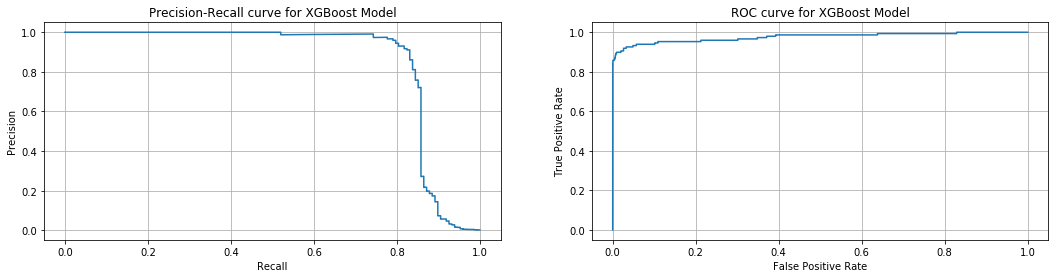

In [59]:
#precision-recall and ROC curves
fig=plt.figure(figsize=(18,4))
ax1 = fig.add_subplot(1,2,1)
plt.title("Precision-Recall curve for XGBoost Model")
ax1.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
ax2 = fig.add_subplot(1,2,2)
plt.title("ROC curve for XGBoost Model")
ax2.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid()
plt.show()

In [60]:
#calculation of areas under Precision-Recall curve and ROC curve
print("The area under the precision-recall curve is {:.3f}".format(average_precision_score(y_test,probs)))
print()
print("The area under the ROC curve is {:.3f}".format(roc_auc_score(y_test,probs)))

The area under the precision-recall curve is 0.856

The area under the ROC curve is 0.976


Recall and precision results are respectively 82% and 91% for fraudulent transactions. 

<span style="color:red"><span style="font-size:18px">Neural Network</span></span>

Area under precision-recall curve (i.e. average_prediction_score) will be optimised and area under ROC curve,confusion matrix, recall and precision will be as well calculated.

We are going to use an artificial neural network with 3 layers (input layer with 29 nodes, 1 hidden layer with 20 nodes and 1 output layer with 1 node). 

In [97]:
# Initialising the ANN
classifier = Sequential()
# Adding the input layer
classifier.add(Dense(units =29 , kernel_initializer = 'uniform', activation = 'relu', input_dim = 29))
# Adding the hidden layer
classifier.add(Dense(units = 20, kernel_initializer = 'uniform', activation = 'relu'))
# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics=['accuracy'])
# Fitting the ANN to the Training set
classifier.fit(X_train, y_train,batch_size = 32,epochs = 100)

Epoch 1/100
199364/199364 [==============================] - 14s 71us/step - loss: 0.0130 - acc: 0.9989
Epoch 2/100
199364/199364 [==============================] - 14s 69us/step - loss: 0.0029 - acc: 0.9994
Epoch 3/100
199364/199364 [==============================] - 14s 70us/step - loss: 0.0028 - acc: 0.9994 1
Epoch 4/100
199364/199364 [==============================] - 14s 68us/step - loss: 0.0026 - acc: 0.9994
Epoch 5/100
199364/199364 [==============================] - 13s 63us/step - loss: 0.0024 - acc: 0.9994
Epoch 6/100
199364/199364 [==============================] - 12s 61us/step - loss: 0.0023 - acc: 0.9995
Epoch 7/100
199364/199364 [==============================] - 14s 68us/step - loss: 0.0023 - acc: 0.9994
Epoch 8/100
199364/199364 [==============================] - 15s 77us/step - loss: 0.0021 - acc: 0.9995
Epoch 9/100
199364/199364 [==============================] - 15s 75us/step - loss: 0.0021 - acc: 0.9995
Epoch 10/100
199364/199364 [==============================] - 

In [98]:
#predictions and calculation of probabilities
y_pred_new=classifier.predict(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_new)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_new)

In [99]:
#setting threshold and confusion matrix calculation
y_pred=y_pred_new>0.5
cm=confusion_matrix(y_test,y_pred)

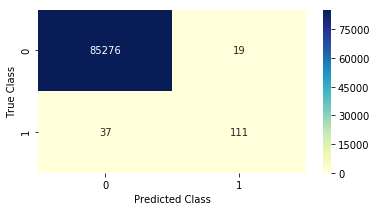

In [100]:
#confusion matrix plot
labels=[0,1]
plt.figure(figsize=(6,3))
sns.heatmap(cm,annot=True,cmap="YlGnBu",xticklabels=labels,yticklabels=labels,fmt='g')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

In [101]:
#metrics report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.85      0.75      0.80       148

   micro avg       1.00      1.00      1.00     85443
   macro avg       0.93      0.87      0.90     85443
weighted avg       1.00      1.00      1.00     85443



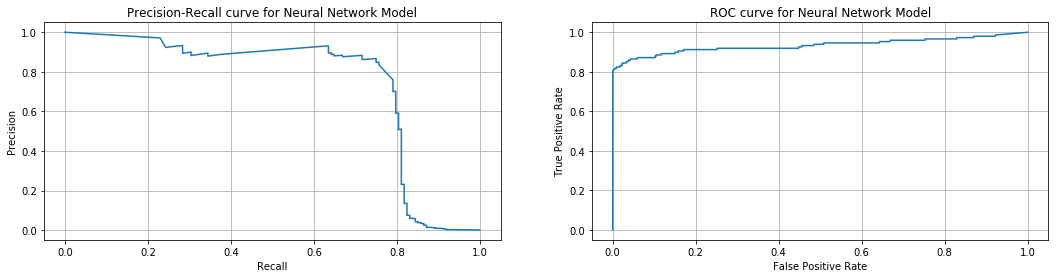

In [102]:
#precision-recall and ROC curves
fig=plt.figure(figsize=(18,4))
ax1 = fig.add_subplot(1,2,1)
plt.title("Precision-Recall curve for Neural Network Model")
ax1.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
ax2 = fig.add_subplot(1,2,2)
plt.title("ROC curve for Neural Network Model")
ax2.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid()
plt.show()

In [103]:
#calculation of areas under Precision-Recall curve and ROC curve
print("The area under the precision-recall curve is {:.3f}".format(average_precision_score(y_test,y_pred_new)))
print()
print("The area under the ROC curve is {:.3f}".format(roc_auc_score(y_test,y_pred_new)))

The area under the precision-recall curve is 0.746

The area under the ROC curve is 0.934


Recall and precision results are respectively 75% and 85% for fraudulent transactions. 

<span style="color:red"><span style="font-size:18px">Neural Network-Balanced weights</span></span>

Area under precision-recall curve (i.e. average_prediction_score) will be optimised and area under ROC curve,confusion matrix, recall and precision will be as well calculated.<br><br>
The same Artificial neural network as last paragraph will be used.

In [90]:
#calculating weights
#class_wt = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
class_wt = {0 : 1. , 1: 20.}
# Initialising the ANN
classifier = Sequential()
# Adding the input layer
classifier.add(Dense(units =29 , kernel_initializer = 'glorot_uniform', activation = 'relu', input_dim = 29))
# Adding the hidden layer
classifier.add(Dense(units = 20, kernel_initializer = 'glorot_uniform', activation = 'relu'))
# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'glorot_uniform', activation = 'sigmoid'))
# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics=['accuracy'])
# Fitting the ANN to the Training set
classifier.fit(X_train, y_train,batch_size = 32,epochs = 100,class_weight = class_wt)

Epoch 1/100
199364/199364 [==============================] - 12s 62us/step - loss: 0.0431 - acc: 0.9986
Epoch 2/100
199364/199364 [==============================] - 11s 54us/step - loss: 0.0266 - acc: 0.9989
Epoch 3/100
199364/199364 [==============================] - 11s 56us/step - loss: 0.0235 - acc: 0.9990
Epoch 4/100
199364/199364 [==============================] - 11s 56us/step - loss: 0.0210 - acc: 0.9988
Epoch 5/100
199364/199364 [==============================] - 11s 55us/step - loss: 0.0200 - acc: 0.9990
Epoch 6/100
199364/199364 [==============================] - 11s 56us/step - loss: 0.0185 - acc: 0.9988
Epoch 7/100
199364/199364 [==============================] - 11s 56us/step - loss: 0.0170 - acc: 0.9989
Epoch 8/100
199364/199364 [==============================] - 12s 58us/step - loss: 0.0168 - acc: 0.9988
Epoch 9/100
199364/199364 [==============================] - 11s 57us/step - loss: 0.0155 - acc: 0.9989
Epoch 10/100
199364/199364 [==============================] - 18

199364/199364 [==============================] - 15s 75us/step - loss: 0.0069 - acc: 0.9989
Epoch 80/100
199364/199364 [==============================] - 13s 67us/step - loss: 0.0049 - acc: 0.9992
Epoch 81/100
199364/199364 [==============================] - 13s 66us/step - loss: 0.0067 - acc: 0.9991
Epoch 82/100
199364/199364 [==============================] - 15s 75us/step - loss: 0.0054 - acc: 0.9992
Epoch 83/100
199364/199364 [==============================] - 15s 73us/step - loss: 0.0053 - acc: 0.9992
Epoch 84/100
199364/199364 [==============================] - 15s 74us/step - loss: 0.0063 - acc: 0.9991 1s - loss: 0.0059 - acc: 0.999 - ETA: 1s - 
Epoch 85/100
199364/199364 [==============================] - 13s 65us/step - loss: 0.0053 - acc: 0.9993
Epoch 86/100
199364/199364 [==============================] - 11s 57us/step - loss: 0.0044 - acc: 0.9994
Epoch 87/100
199364/199364 [==============================] - 12s 58us/step - loss: 0.0067 - acc: 0.9991
Epoch 88/100
199364/1993

In [91]:
#predictions and calculation of probabilities
y_pred_new=classifier.predict(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_new)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_new)

In [92]:
#setting threshold and confusion matrix calculation
y_pred=y_pred_new>0.5
cm=confusion_matrix(y_test,y_pred)

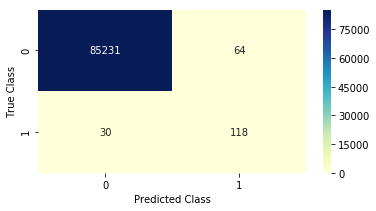

In [93]:
#confusion matrix plot
labels=[0,1]
plt.figure(figsize=(6,3))
sns.heatmap(cm,annot=True,cmap="YlGnBu",xticklabels=labels,yticklabels=labels,fmt='g')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

In [94]:
#metrics report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.65      0.80      0.72       148

   micro avg       1.00      1.00      1.00     85443
   macro avg       0.82      0.90      0.86     85443
weighted avg       1.00      1.00      1.00     85443



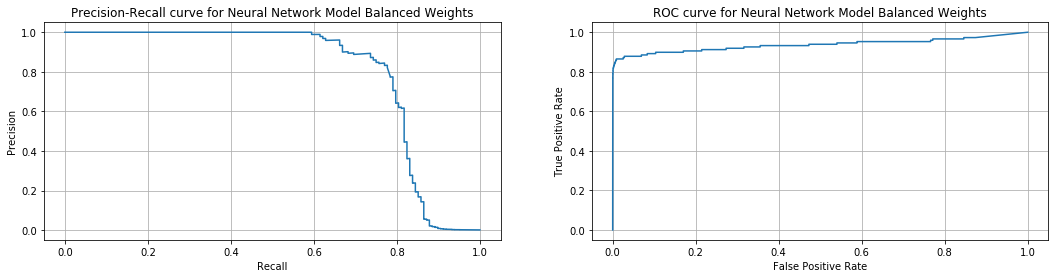

In [95]:
#precision-recall and ROC curves
fig=plt.figure(figsize=(18,4))
ax1 = fig.add_subplot(1,2,1)
plt.title("Precision-Recall curve for Neural Network Model Balanced Weights")
ax1.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
ax2 = fig.add_subplot(1,2,2)
plt.title("ROC curve for Neural Network Model Balanced Weights")
ax2.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid()
plt.show()

In [96]:
#calculation of areas under Precision-Recall curve and ROC curve
print("The area under the precision-recall curve is {:.3f}".format(average_precision_score(y_test,y_pred_new)))
print()
print("The area under the ROC curve is {:.3f}".format(roc_auc_score(y_test,y_pred_new)))

The area under the precision-recall curve is 0.803

The area under the ROC curve is 0.936


Recall and precision results are respectively 80% and 65% for fraudulent transactions. 

As it happens in Logistic Regression model, balanced weight parameter worsens average precision metrics and improves recall metrics.

<span style="color:blue"><span style="font-size:25px">Train-split model results</span></span>

__The model which achieves the best results is XGBoost with 0.856 of average precision score. We have considered for all these models all the features and we have kept the data unbalanced. However in some models we have used special parameter which gives different weights for cost function depending on class and compensates the original unbalancing.__

The splitting for all the models has been 70% training and 30% validation. This splitting is not the best one and has been chosen to be able to show confusion matrix, precison recall curve and ROC curve.<br> Now, we are going to use for the 2 best models (Random Forest and XGBoost) cross validation splitting and calculate average precision score, area under the ROC curve, precision and recall and check if we obtain any improvement for these metrics.

<span style="color:blue"><span style="font-size:25px">Models (cross validation)</span></span>

In these models we have performed a previous tuning and we have passed the best model parameters for cross-validation split. 

In [82]:
#normalisation of Amount features
new_sc=StandardScaler()
transactions[['Amount']]=new_sc.fit_transform(transactions[['Amount']])
new_transactions=transactions.copy()
new_transactions.drop(['Class'],axis=1,inplace=True)

<span style="color:red"><span style="font-size:18px">Random Forest</span></span>

Areas under Precision-Recall and ROC curves will be calculated as well as precision and recall metrics.

In [83]:
K=5
kfold= StratifiedKFold(K, True, 1)# split keeping the same ratio of minority and majority classes
sum_average_precision_score=0
sum_roc_auc_score=0
sum_precision_score=0
sum_recall_score=0
for train_index,test_index in kfold.split(new_transactions,y):
    X_training=new_transactions.values[train_index,:]
    X_testing=new_transactions.values[test_index,:]
    y_training=y[train_index]
    y_testing=y[test_index]
    rf_model=RandomForestClassifier(n_estimators=150,min_samples_leaf=3,random_state=14,n_jobs=-1)
    rf_model.fit(X_training,y_training)
    probs = rf_model.predict_proba(X_testing)
    probs = probs[:, 1]
    sum_average_precision_score +=average_precision_score(y_testing,probs)
    sum_roc_auc_score +=roc_auc_score(y_testing,probs)
    y_pred=rf_model.predict(X_testing)
    sum_precision_score +=precision_score(y_testing,y_pred)
    sum_recall_score +=recall_score(y_testing,y_pred)
print("The area under the precision-recall curve is {:.3f}".format(sum_average_precision_score/K))
print()
print("The area under the ROC curve is {:.3f}".format(sum_roc_auc_score/K))
print()
print("The precision is {:.3f}".format(sum_precision_score/K))
print()
print("The recall is {:.3f}".format(sum_recall_score/K))

The area under the precision-recall curve is 0.847

The area under the ROC curve is 0.955

The precision is 0.936

The recall is 0.774


<span style="color:red"><span style="font-size:18px">XGBoost</span></span>

Areas under Precision-Recall and ROC curves will be calculated as well as precision and recall metrics.

In [84]:
K=5
kfold= StratifiedKFold(K, True, 1)# split keeping the same ratio of minority and majority classes
sum_average_precision_score=0
sum_roc_auc_score=0
sum_precision_score=0
sum_recall_score=0
for train_index,test_index in kfold.split(new_transactions,y):
    X_training=new_transactions.values[train_index,:]
    X_testing=new_transactions.values[test_index,:]
    y_training=y[train_index]
    y_testing=y[test_index]
    xgb_model=XGBClassifier(learning_rate =0.15,n_estimators=200,
        max_depth=6,min_child_weight=1,gamma=0,subsample=0.8,colsample_bytree=0.8,
        objective= 'binary:logistic',nthread=4,scale_pos_weight=20,seed=20,n_jobs=-1)
    xgb_model.fit(X_training,y_training)
    probs = xgb_model.predict_proba(X_testing)
    probs = probs[:, 1]
    sum_average_precision_score +=average_precision_score(y_testing,probs)
    sum_roc_auc_score +=roc_auc_score(y_testing,probs)
    y_pred=xgb_model.predict(X_testing)
    sum_precision_score +=precision_score(y_testing,y_pred)
    sum_recall_score +=recall_score(y_testing,y_pred) 
    
print("The area under the precision-recall curve is {:.3f}".format(sum_average_precision_score/K))
print()
print("The area under the ROC curve is {:.3f}".format(sum_roc_auc_score/K))
print()
print("The precision is {:.3f}".format(sum_precision_score/K))
print()
print("The recall is {:.3f}".format(sum_recall_score/K))   

The area under the precision-recall curve is 0.863

The area under the ROC curve is 0.982

The precision is 0.940

The recall is 0.813


We notice that we have improved our results for both models.<br>

Thus, for our unbalanced data these are the final results:

Random Forest : average precision score     0.847<br>
XGBoost       : average precision score         0.863

Finally the best score was obtained by XGBoost with an average precision score of 0.863 . This XGBoost model will be used furtherly for testing features reduction and balancing data.

<span style="color:blue"><span style="font-size:25px">Features Reduction</span></span>

When correlation matrix was calculated we notice that there were weak and middle correlations between __Amount__ feature and some of V1...V28 features. This correlation may indicate that this feature could be eliminated without worsening main metrics. This may lead to model simplification and time processing improvement. Nevertheless as the other features are not correlated themselves, we cannot expect a significant change.<br> 

We will check this feature reduction using the best model(XGBoost) for cross validation. Parameters have been tuned and best values have been applied.


In [85]:
transactions_w_amount=new_transactions.copy()
transactions_w_amount.drop(['Amount'],axis=1,inplace=True)

In [86]:
K=5
kfold= StratifiedKFold(K, True, 1)
sum_average_precision_score=0
sum_roc_auc_score=0
sum_precision_score=0
sum_recall_score=0
for train, test in kfold.split(transactions_w_amount,y):
    X_training=transactions_w_amount.values[train,:]
    X_testing=transactions_w_amount.values[test,:]
    y_training=y[train]
    y_testing=y[test]
    xgb_model=XGBClassifier(learning_rate =0.15,n_estimators=200,
        max_depth=6,min_child_weight=1,gamma=0,subsample=0.8,colsample_bytree=0.8,
        objective= 'binary:logistic',nthread=4,scale_pos_weight=20,seed=20,n_jobs=-1)
    xgb_model.fit(X_training,y_training)
    probs = xgb_model.predict_proba(X_testing)
    probs = probs[:, 1]
    sum_average_precision_score +=average_precision_score(y_testing,probs)
    sum_roc_auc_score +=roc_auc_score(y_testing,probs)
    y_pred=xgb_model.predict(X_testing)
    sum_precision_score +=precision_score(y_testing,y_pred)
    sum_recall_score +=recall_score(y_testing,y_pred) 
    
print("The area under the precision-recall curve is {:.3f}".format(sum_average_precision_score/K))
print()
print("The area under the ROC curve is {:.3f}".format(sum_roc_auc_score/K))
print()
print("The precision is {:.3f}".format(sum_precision_score/K))
print()
print("The recall is {:.3f}".format(sum_recall_score/K))   

The area under the precision-recall curve is 0.859

The area under the ROC curve is 0.982

The precision is 0.938

The recall is 0.811


There is a slight worsening when __Amount__ feature is suppressed and this feature might be erased from original data features. Nevertheless, as we are looking for the optimum value,we are going to keep all features for next steps.

<span style="color:blue"><span style="font-size:25px">Balancing data</span></span>

Hereinafter, we are going to review different methods to minimize data unbalance by resampling data.

There are 3 main possible solutions concerning resample data:
1. Undersampling majority class
2. Oversampling minority class (copying data)
3. Synthetic sampling minority class (syntethizing new data)

In undersampling majority class technique, we randomly delete the class which has sufficient observations so that the comparative ratio of two classes is significant. Although this approach is really simple to follow but there is a high possibility that the data that we are deleting may contain important information about the predictive class.

In oversampling minority class technique, for the unbalanced class, we randomly increase the number of observations which are just copies of existing samples.This ideally gives us sufficient number of samples to play with.The oversampling may lead to overfitting to the training data

In syntethizing minority class technique, we synthetically manufacture observations of unbalanced classes which are similar to the existing using nearest neighbors classification.

Syntethizing minority class samples will be the chosen option. A care must be taken because if it is applied incorrectly, we can get  "over optimistic" results. As we are using cross-validation splitting, we can oversample minority class data before splitting or oversample minority class within splitting.   

<span style="color:red"><span style="font-size:20px">Oversampling before cross-validation</span></span>

In [87]:
sm_before=SMOTE(random_state=12)
X_before_smo,y_before_smo=sm_before.fit_sample(new_transactions,y.ravel())

In [88]:
K=5
kfold= StratifiedKFold(K, True, 1)
sum_average_precision_score=0
sum_roc_auc_score=0
sum_precision_score=0
sum_recall_score=0
for train, test in kfold.split(X_before_smo,y_before_smo):
    X_training=X_before_smo[train,:]
    X_testing=X_before_smo[test,:]
    y_training=y_before_smo[train]
    y_testing=y_before_smo[test]
    xgb_model=XGBClassifier(learning_rate =0.15,n_estimators=300,
        max_depth=8,min_child_weight=1,gamma=0,subsample=0.5,colsample_bytree=0.8,
        objective= 'binary:logistic',nthread=4,scale_pos_weight=1,seed=20,n_jobs=-1)
    xgb_model.fit(X_training,y_training)
    probs = xgb_model.predict_proba(X_testing)
    probs = probs[:, 1]
    sum_average_precision_score +=average_precision_score(y_testing,probs)
    sum_roc_auc_score +=roc_auc_score(y_testing,probs)
    y_pred=xgb_model.predict(X_testing)
    sum_precision_score +=precision_score(y_testing,y_pred)
    sum_recall_score +=recall_score(y_testing,y_pred) 
    
print("The area under the precision-recall curve is {:.6f}".format(sum_average_precision_score/K))
print()
print("The area under the ROC curve is {:.6f}".format(sum_roc_auc_score/K))
print()
print("The precision is {:.6f}".format(sum_precision_score/K))
print()
print("The recall is {:.6f}".format(sum_recall_score/K))   

The area under the precision-recall curve is 0.999996

The area under the ROC curve is 0.999996

The precision is 0.999613

The recall is 1.000000


The results are almost perfect, nevertheless there is a problem. It makes no sense to create instances based on our current minority class and then exclude an instance for validation, pretending we didn’t generate it using data that is still in the training set.If we oversample original data before cross-validation there are a many samples in test set which have been generated from training samples. So if we would test new samples outside original dataset, we would get a very big error.

<span style="color:red"><span style="font-size:20px">Oversampling within cross-validation</span></span>

In [89]:
K=5
kfold= StratifiedKFold(K, True, 1)
sum_average_precision_score=0
sum_roc_auc_score=0
sum_precision_score=0
sum_recall_score=0
for train, test in kfold.split(new_transactions,y):
    X_training=new_transactions.values[train,:]
    X_testing=new_transactions.values[test,:]
    y_training=y[train]
    y_testing=y[test]
    sm=SMOTE(random_state=12)
    X_training_smo,y_training_smo=sm.fit_sample(X_training,y_training.ravel())
    xgb_model=XGBClassifier(learning_rate =0.15,n_estimators=300,
        max_depth=8,min_child_weight=1,gamma=0,subsample=0.5,colsample_bytree=0.8,
        objective= 'binary:logistic',nthread=4,scale_pos_weight=1,seed=20,n_jobs=-1)
    xgb_model.fit(X_training_smo,y_training_smo)
    probs = xgb_model.predict_proba(X_testing)
    probs = probs[:, 1]
    sum_average_precision_score +=average_precision_score(y_testing,probs)
    sum_roc_auc_score +=roc_auc_score(y_testing,probs)
    y_pred=xgb_model.predict(X_testing)
    sum_precision_score +=precision_score(y_testing,y_pred)
    sum_recall_score +=recall_score(y_testing,y_pred) 
    
print("The area under the precision-recall curve is {:.3f}".format(sum_average_precision_score/K))
print()
print("The area under the ROC curve is {:.3f}".format(sum_roc_auc_score/K))
print()
print("The precision is {:.3f}".format(sum_precision_score/K))
print()
print("The recall is {:.3f}".format(sum_recall_score/K))   

The area under the precision-recall curve is 0.860

The area under the ROC curve is 0.979

The precision is 0.833

The recall is 0.835


From these results it can be noticed, in this problem,by increasing minority class samples, that SMOTE function gives slight worsening results concerning average precision score. Nevertheless there is an improvement of recall metric due to false negative predictions reduction. 

In credit card fraud detection, it is crucial to detect all non fraudulent and fraudulent transactions. But if we do not have 100% detection, which of the following cases it is more important to be lowered:
1. a fraudulent transaction considered as non fraudulent ?
2. a non fraudulent transaction considered as fraudulent ?<br><br>

Oversampling minority class (SMOTE) decreases false negative predictions (case nº1) but increases False positive predictions(case nº2). Average precision score seems to be a trade off result for these false predictions.    

__Our best result has been achived with a XGBoost model with balanced weights parameter. The final average precision score was 0.863. This result was accomplished for original unbalanced data.<br><br>
With balanced data using SMOTE technique we can get a little worse average precision score but with a better recall results. Thus, for balanced data, more real fraudulent transactions are detected at the expense of less real non fraudulent transactions detected.__